In [1]:
from pyspark.sql import SparkSession, DataFrame, Window
import pyspark.sql.functions as F
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_college_date(spark: SparkSession, data_location: str = '../data/*.csv') -> DataFrame:
    df = spark.read.csv(data_location, header='true')
    return df

In [3]:
spark = SparkSession.builder.appName('HistoricCollegeData') \
        .getOrCreate()

21/08/26 16:38:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
df = read_college_date(spark=spark)

In [5]:
df.limit(5).toPandas()

21/08/26 10:51:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,FEDSCHCD,BOOKSUPPLY,ROOMBOARD_ON,OTHEREXPENSE_ON,ROOMBOARD_OFF,OTHEREXPENSE_OFF,OTHEREXPENSE_FAM,ENDOWBEGIN,ENDOWEND,DOLPROVIDER
0,100636,01230800,012308,Community College of the Air Force,Montgomery,AL,36114-3011,NULL,NULL,NULL,...,NULL,0,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
1,100654,00100200,001002,Alabama A & M University,Normal,AL,35762,NULL,NULL,NULL,...,NULL,900,4500,2300,4500,2300,1300,NULL,NULL,NULL
2,100663,00105200,001052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NULL,NULL,NULL,...,NULL,900,8627,2438,8823,3375,3375,211439180,251004030,NULL
3,100690,02503400,025034,Amridge University,Montgomery,AL,36117-3553,NULL,NULL,NULL,...,NULL,600,NULL,NULL,7782,1474,1474,0,0,NULL
4,100706,00105500,001055,University of Alabama in Huntsville,Huntsville,AL,35899,NULL,NULL,NULL,...,NULL,720,6380,2015,6380,2280,2280,18033185,20866634,NULL


In [6]:
results = df.groupBy('INSTNM').agg(F.count('INSTNM').alias('UniqueInstituitionCount'))
results.sort(F.col('UniqueInstituitionCount').desc()).show(20)


+--------------------+-----------------------+
|              INSTNM|UniqueInstituitionCount|
+--------------------+-----------------------+
|Marinello School ...|                    133|
|Stevens-Henager C...|                    109|
|    Columbia College|                     91|
|    Bryan University|                     88|
|McCann School of ...|                     86|
|Brittany Beauty A...|                     75|
|Southwestern College|                     72|
|       Union College|                     72|
|   Bethel University|                     72|
| Westminster College|                     72|
|Western Technical...|                     72|
|  Lincoln University|                     68|
|Cannella School o...|                     68|
|Arthur's Beauty C...|                     68|
|Academy of Cosmet...|                     62|
|Interactive Colle...|                     60|
|Business Career T...|                     59|
|The Beauty Institute|                     56|
|         UEI

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

results = df.groupBy('INSTNM').agg(F.count('INSTNM').alias('UniqueInstituitionCount')).sort(F.col('UniqueInstituitionCount').desc()).toPandas()
results.head()
# results.sort(F.col('UniqueInstituitionCount').desc()).plot()

,INSTNM,UniqueInstituitionCount
0,Marinello School of Beauty,133
1,Stevens-Henager College,109
2,Columbia College,91
3,Bryan University,88
4,McCann School of Business & Technology,86


In [6]:
results.shape

(11207, 2)

<AxesSubplot:>

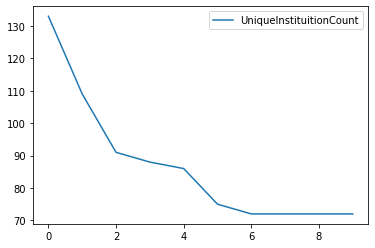

In [7]:
results.head(10).plot()

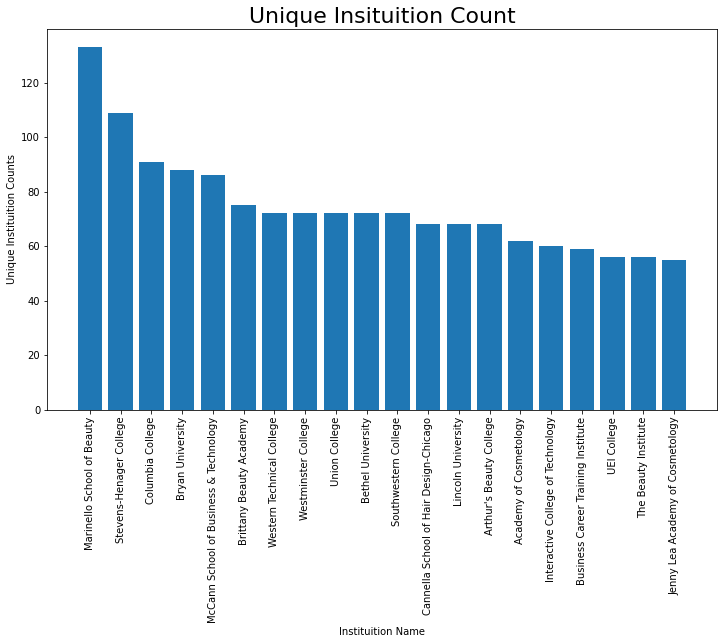

In [11]:
x_ts = results['INSTNM'].head(20)
y_ans_val = results['UniqueInstituitionCount'].head(20)
plt.figure(figsize=(12, 7))
plt.bar(x_ts, y_ans_val)

plt.ylabel('Unique Instituition Counts')
plt.xlabel('Instituition Name')
plt.xticks(rotation=90)
plt.title('Unique Insituition Count', size=22)

plt.show()


In [23]:
# Which States has the highest number of student?
def pull_number_of_student_per_states(df: DataFrame):
    win = Window.partitionBy('STABBR').orderBy(F.col('NUM4_PUB').desc())
    df = df.withColumn('rowNum', F.row_number().over(win))
    df = df.groupby('STABBR').agg(F.sum(F.col('NUM4_PUB')).alias('total_number_of_students'))
    df.sort(F.col('total_number_of_students').desc()).limit(10).show()

# pull_number_of_student_per_states(df)

+------+------------------------+
|STABBR|total_number_of_students|
+------+------------------------+
|    CA|               1154205.0|
|    TX|                881766.0|
|    NY|                814605.0|
|    FL|                557794.0|
|    OH|                471870.0|
|    PA|                432544.0|
|    GA|                397956.0|
|    MI|                376380.0|
|    NC|                344533.0|
|    IL|                341352.0|
+------+------------------------+



In [31]:
def pull_avg_number_of_students_public_instituition(df: DataFrame):
    win = Window.partitionBy('INSTNM').orderBy(F.col('NUM4_PUB').desc())
    df = df.withColumn('rowNum', F.row_number().over(win))
    results = df.groupBy('INSTNM').agg(F.avg('NUM4_PUB').alias('avg_number_student_count'))
    results.sort(F.col('avg_number_student_count').desc()).show(20)

def pull_avg_number_of_students_private_instituition(df: DataFrame):
    win = Window.partitionBy('INSTNM').orderBy(F.col('NUM4_PRIV').desc())
    df = df.withColumn('rowNum', F.row_number().over(win))
    results = df.groupBy('INSTNM').agg(F.avg('NUM4_PRIV').alias('avg_number_student_count_private'))
    results.sort(F.col('avg_number_student_count_private').desc()).show(20)


In [38]:
pull_avg_number_of_students_private_instituition(df)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib64/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/usr/lib64/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/usr/lib64/python3.9/logging/__init__.py", line 666, in format
    s = self.formatMessage(record)
  File "/usr/lib64/python3.9/logging/__init__.py", line 635, in formatMessage
    return self._style.format(record)
  File "/usr/lib64/python3.9/logging/__init__.py", line 434, in format
    return self._format(record)
  File "/usr/lib64/python3.9/logging/__init__.py", line 430, in _format
    return self._fmt % record.__dict__
ValueError: unsupported format character '%' (0x25) at index 13
Call stack:
  File "/usr/lib64/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib64/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/Abuton

+--------------------+--------------------------------+
|              INSTNM|avg_number_student_count_private|
+--------------------+--------------------------------+
|University of Pho...|                         12314.0|
|University of Pho...|               5538.666666666667|
|Ultimate Medical ...|                          5038.0|
|Keiser University...|              2916.2727272727275|
|Full Sail University|              2684.3333333333335|
| New York University|               2645.818181818182|
|Colorado Technica...|              2356.8571428571427|
|  Liberty University|              2350.4545454545455|
|St. John's Univer...|              2308.3636363636365|
|Ultimate Medical ...|              2202.4444444444443|
|Rochester Institu...|                          2141.0|
|Universidad Ana G...|              2134.7272727272725|
| Syracuse University|              1943.8181818181818|
|   Baylor University|              1910.7272727272727|
|Everest Universit...|                         1

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib64/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/usr/lib64/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/usr/lib64/python3.9/logging/__init__.py", line 666, in format
    s = self.formatMessage(record)
  File "/usr/lib64/python3.9/logging/__init__.py", line 635, in formatMessage
    return self._style.format(record)
  File "/usr/lib64/python3.9/logging/__init__.py", line 434, in format
    return self._format(record)
  File "/usr/lib64/python3.9/logging/__init__.py", line 430, in _format
    return self._fmt % record.__dict__
ValueError: unsupported format character '%' (0x25) at index 13
Call stack:
  File "/usr/lib64/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib64/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/Abuton